In [1]:
import gymnasium as gym
from gymnasium import spaces

In [3]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

ticker = "MSFT"
df = yf.download(ticker, period='60d', interval="2m")

df.columns = [i[0] for i in df.columns]

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


In [4]:


# Function to compute RSI
def compute_rsi(data, window=14):
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    return 100 - (100 / (1 + rs))

# Function to compute MACD
def compute_macd(data, short_window=12, long_window=26, signal_window=9):
    short_ema = data.ewm(span=short_window, adjust=False).mean()
    long_ema = data.ewm(span=long_window, adjust=False).mean()
    macd = short_ema - long_ema
    signal_line = macd.ewm(span=signal_window, adjust=False).mean()
    return macd, signal_line

# Compute Indicators
df["SMA_10"] = df["High"].rolling(window=10).mean()
df["EMA_10"] = df["High"].ewm(span=10, adjust=False).mean()
df["RSI_14"] = compute_rsi(df["High"], window=14)
df["MACD"], df["Signal_Line"] = compute_macd(df["High"])
df["BB_Mid"] = df["High"].rolling(window=20).mean()
df["BB_Std"] = df["High"].rolling(window=20).std()
df["BB_Upper"] = df["BB_Mid"] + (df["BB_Std"] * 2)
df["BB_Lower"] = df["BB_Mid"] - (df["BB_Std"] * 2)

price_volume = (df["High"] * df["Volume"]).rolling(window=20).sum().shift(1)
volume_sum = df["Volume"].rolling(window=20).sum().shift(1)
df["VWAP"] = price_volume / volume_sum


fib_window = 26  # adjust to match your feature engineering style

rolling_high = df["High"].rolling(window=fib_window).max().shift(1)
rolling_low = df["Low"].rolling(window=fib_window).min().shift(1)

df["Fib_23.6"] = rolling_low + 0.236 * (rolling_high - rolling_low)
df["Fib_38.2"] = rolling_low + 0.382 * (rolling_high - rolling_low)
df["Fib_61.8"] = rolling_low + 0.618 * (rolling_high - rolling_low)

df.drop(columns=["BB_Std"], inplace=True)

# Shift indicators to prevent data leakage

for col in ["SMA_10", "EMA_10", "RSI_14", "MACD", "Signal_Line", "VWAP", "BB_Mid", "BB_Upper", "BB_Lower"]:
    df[col] = df[col].shift(1)

# Drop NaN values resulting from rolling calculations
df.dropna(inplace=True)


In [7]:
df

,Close,High,Low,Open,Volume,SMA_10,EMA_10,RSI_14,MACD,Signal_Line,BB_Mid,BB_Upper,BB_Lower,VWAP,Fib_23.6,Fib_38.2,Fib_61.8
Datetime,,,,,,,,,,,,,,,,,
2025-02-24 15:22:00+00:00,399.679993,400.359985,399.470001,399.695007,176310,400.936005,401.139486,34.991452,-1.451712,-1.625985,401.534422,403.138729,399.930116,401.707731,401.691804,403.159103,405.530900
2025-02-24 15:24:00+00:00,400.415009,400.670013,399.410004,399.744995,148168,400.906003,400.997759,37.455541,-1.419254,-1.584638,401.468997,403.154931,399.783064,401.586177,401.621007,403.044507,405.345507
2025-02-24 15:26:00+00:00,399.695007,400.480011,399.369995,400.393005,137562,400.869003,400.938169,39.500901,-1.352918,-1.538294,401.416498,403.134607,399.698389,401.533755,401.132486,402.253765,404.066243
2025-02-24 15:28:00+00:00,399.790009,399.970001,399.579987,399.684998,117335,400.885504,400.854867,38.572169,-1.300685,-1.490773,401.305998,402.962406,399.649591,401.489049,400.660486,401.489765,402.830243
2025-02-24 15:30:00+00:00,399.910004,400.070007,399.660004,399.815002,123465,400.801505,400.693983,37.196247,-1.285623,-1.449743,401.139499,402.611122,399.667875,401.382891,400.507087,401.241467,402.428547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-09 19:50:00+00:00,391.640015,391.709991,389.980011,389.980011,576934,389.340509,389.134258,65.822963,1.108213,1.152422,388.425743,391.005423,385.846063,388.354942,383.987438,385.161280,387.058722
2025-04-09 19:52:00+00:00,392.190002,392.649994,391.640015,391.640015,532014,389.577518,389.602573,74.721660,1.243468,1.170631,388.721243,391.387025,386.055462,388.637469,384.360315,385.764834,388.035153
2025-04-09 19:54:00+00:00,390.130005,393.225006,389.940002,392.239990,839483,389.886517,390.156650,77.362909,1.410253,1.218555,389.051244,391.948677,386.153810,389.176640,385.090222,386.534891,388.870108


In [17]:
import gymnasium as gym
from gymnasium import spaces
import numpy as np
import pandas as pd
from stable_baselines3 import DQN


In [19]:
class TradingEnv(gym.Env):
    def __init__(self, df, initial_cash=1000, context_width=10, offset=3):
        super(TradingEnv, self).__init__()

        self.df = df.reset_index(drop=True)
        self.initial_cash = initial_cash
        self.context_width = context_width
        self.offset = offset

        self.action_space = spaces.Discrete(3)  # Hold, Buy, Sell

        # Observation shape: (context_width, features + 2)
        self.observation_space = spaces.Box(
            low=-np.inf,
            high=np.inf,
            shape=(self.context_width * (self.df.shape[1] + 2),),
            dtype=np.float32
        )


        self.reset()

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.context_width
        self.cash = self.initial_cash
        self.stock_held = 0
    
        # You can also optionally use the seed to make resets reproducible
        if seed is not None:
            np.random.seed(seed)
    
        obs = self._get_obs()
        info = {} 
    
        return obs, info

    def _get_obs(self):
        window = self.df.iloc[self.current_step - self.context_width:self.current_step].values.astype(np.float32)
        cash_stock = np.array([[self.cash, self.stock_held]] * self.context_width, dtype=np.float32)
        obs = np.concatenate((window, cash_stock), axis=1)
        return obs.flatten()  # FLATTEN to 1D


    def step(self, action):
        terminated = False
        truncated = False
        info = {}
    
        current_price = self.df.iloc[self.current_step]["Close"]
        prev_total_asset = self.cash + self.stock_held * current_price
    
        # Execute action
        if action == 1 and self.cash >= current_price:  # Buy
            self.cash -= current_price
            self.stock_held += 1
        elif action == 2 and self.stock_held > 0:  # Sell
            self.cash += current_price
            self.stock_held -= 1
    
        self.current_step += 1
    
        if self.current_step + self.offset >= len(self.df):
            terminated = True
    
        future_price = self.df.iloc[min(self.current_step + self.offset, len(self.df)-1)]["Close"]
        current_total_asset = self.cash + self.stock_held * future_price
        reward = current_total_asset - prev_total_asset
    
        obs = self._get_obs()
        return obs, reward, terminated, truncated, info


    def render(self, mode="human"):
        price = self.df.iloc[self.current_step]["Close"]
        total = self.cash + self.stock_held * price
        print(f"Step: {self.current_step}, Cash: {self.cash:.2f}, Stock: {self.stock_held}, Total: {total:.2f}")


In [21]:
df

,Close,High,Low,Open,Volume,SMA_10,EMA_10,RSI_14,MACD,Signal_Line,BB_Mid,BB_Upper,BB_Lower,VWAP,Fib_23.6,Fib_38.2,Fib_61.8
Datetime,,,,,,,,,,,,,,,,,
2025-02-24 15:22:00+00:00,0.905631,0.909152,0.907552,0.906625,0.026295,0.926347,0.928548,34.991452,0.304599,0.244130,0.936171,0.925072,0.928422,0.938191,401.691804,403.159103,405.530900
2025-02-24 15:24:00+00:00,0.918062,0.914387,0.906556,0.907470,0.022043,0.925816,0.925962,37.455541,0.307879,0.249165,0.934965,0.925389,0.926176,0.935922,401.621007,403.044507,405.345507
2025-02-24 15:26:00+00:00,0.905885,0.911179,0.905892,0.918422,0.020440,0.925161,0.924875,39.500901,0.314581,0.254810,0.933998,0.924991,0.924883,0.934943,401.132486,402.253765,404.066243
2025-02-24 15:28:00+00:00,0.907492,0.902567,0.909377,0.906456,0.017384,0.925453,0.923356,38.572169,0.319859,0.260598,0.931961,0.921621,0.924138,0.934108,400.660486,401.489765,402.830243
2025-02-24 15:30:00+00:00,0.909521,0.904256,0.910705,0.908653,0.018310,0.923965,0.920421,37.196247,0.321381,0.265595,0.928893,0.914745,0.924417,0.932127,400.507087,401.241467,402.428547
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-09 19:50:00+00:00,0.769660,0.763087,0.750042,0.742437,0.086831,0.720999,0.709561,65.822963,0.563247,0.582521,0.694615,0.687599,0.713339,0.688905,383.987438,385.161280,387.058722
2025-04-09 19:52:00+00:00,0.778962,0.778960,0.777593,0.770492,0.080043,0.725196,0.718104,74.721660,0.576912,0.584739,0.700061,0.695068,0.716536,0.694180,384.360315,385.764834,388.035153
2025-04-09 19:54:00+00:00,0.744123,0.788670,0.749377,0.780632,0.126503,0.730668,0.728210,77.362909,0.593764,0.590576,0.706142,0.706060,0.718038,0.704245,385.090222,386.534891,388.870108


Using cuda device
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.734    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 528      |
|    time_elapsed     | 33       |
|    total_timesteps  | 17856    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.274    |
|    n_updates        | 4438     |
----------------------------------
----------------------------------
| rollout/            |          |
|    exploration_rate | 0.469    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 497      |
|    time_elapsed     | 71       |
|    total_timesteps  | 35712    |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.255    |
|    n_updates        | 8902     |
----------------------------------
----------------------------------
| rollout/            |          |
| 

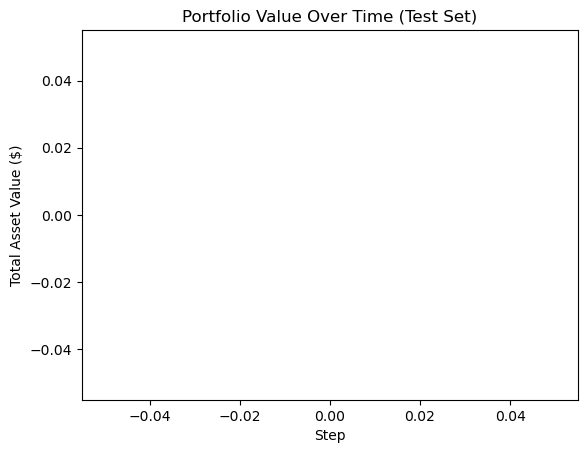

In [23]:
# !pip install stable-baselines3[extra]
from sklearn.preprocessing import MinMaxScaler

# Apply scaling only to selected columns
scale_cols = ['Close', 'High', 'Low', 'Open', 'Volume', 'SMA_10', 'EMA_10', 
              'MACD', 'Signal_Line', 'BB_Mid', 'BB_Upper', 'BB_Lower', 'VWAP']

scaler = MinMaxScaler()
df[scale_cols] = scaler.fit_transform(df[scale_cols])

context_width=10
offset=5


split_point = int(len(df) * 0.7)
train_df = df[:split_point]
test_df = df[split_point:]



train_env = TradingEnv(train_df, context_width=10, offset=5)


from stable_baselines3.common.vec_env import DummyVecEnv


steps_per_episode = df.shape[0] - context_width
total_timesteps = 100 * steps_per_episode


train_env = DummyVecEnv([lambda: train_env])
model = DQN("MlpPolicy", train_env, verbose=1)
model.learn(total_timesteps=total_timesteps)


test_env = TradingEnv(test_df, context_width=10, offset=5)
obs, _ = test_env.reset()
done = False

total_reward = 0
while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)
    total_reward += reward
    test_env.render()



portfolio_values = []

while not done:
    action, _ = model.predict(obs, deterministic=True)
    obs, reward, done, _, _ = test_env.step(action)
    
    current_price = test_df.iloc[test_env.current_step]["Close"]
    current_value = test_env.cash + test_env.stock_held * current_price
    portfolio_values.append(current_value)

# Then plot
import matplotlib.pyplot as plt
plt.plot(portfolio_values)
plt.title("Portfolio Value Over Time (Test Set)")
plt.xlabel("Step")
plt.ylabel("Total Asset Value ($)")
plt.show()

In [61]:
from stable_baselines3.common.env_checker import check_env

env = TradingEnv(df)
check_env(env)  # optional, makes sure env is gym-compliant

In [ ]:

model = DQN("MlpPolicy", env, verbose=1)
model.learn(total_timesteps=100_000)